In [4]:
import numpy as np
from scipy.signal import firwin, filtfilt, hilbert

def get_theta_phase(lfp, spike_times, sampling_rate, peakFreq, filtHalfBandWidth=2, powerThresh=5):
    """
    Calculate the theta phase of spikes based on the LFP using the corrected bad data handling logic.

    Parameters:
    - lfp: Local Field Potential time series.
    - spike_times: Times (in seconds) at which the spikes occurred.
    - sampling_rate: The sampling rate of the LFP.
    - peakFreq: The central frequency around which the LFP is filtered.
    - filtHalfBandWidth: Half bandwidth for filtering. Default is 3 Hz.
    - powerThresh: Threshold (percentile) for minimum power per cycle. Default is 5.

    Returns:
    - spike_phases: Theta phase (in radians) of spikes.
    """

    # 1. FILTER THE LFP AROUND THE PEAK FREQUENCY
    nyq = 0.5 * sampling_rate
    low = (peakFreq - filtHalfBandWidth) / nyq
    high = (peakFreq + filtHalfBandWidth) / nyq
    taps = firwin(round(sampling_rate) + 1, [low, high], pass_zero=False, window='blackman', fs=sampling_rate)
    padlen = min(3 * (len(taps) - 1), len(lfp) - 1)
    theta_lfp = filtfilt(taps, 1, lfp, padlen=padlen)

    # 2. EXTRACT INSTANTANEOUS PHASE USING HILBERT TRANSFORM
    analytic_signal = hilbert(theta_lfp)
    eegPhase = np.angle(analytic_signal)
    eegPhase = np.mod(eegPhase, 2 * np.pi)

    # 3. IDENTIFY AND HANDLE PHASE TRANSITIONS AND SLIPS
    phaseTrans = np.diff(eegPhase) < -np.pi
    phaseTrans = np.hstack(([True], phaseTrans, [True]))
    phaseSlips = np.hstack(([False], np.diff(np.unwrap(eegPhase)) < 0, [False]))
    phaseTrans[phaseSlips] = False

    # 4. CALCULATE EEG POWER AND POWER PER CYCLE
    cycleN = np.cumsum(phaseTrans[:-1])
    power = theta_lfp**2
    powerPerCycle = np.bincount(cycleN, power) / np.bincount(cycleN)
    
    # Calculate cycle length
    cycleLength = np.bincount(cycleN)
    
    # 5. HANDLE BAD DATA
    # Power threshold
    thresh = np.percentile(powerPerCycle, powerThresh)
    badPowerCycle = np.where(powerPerCycle < thresh)[0]
    badPowerInd = np.isin(cycleN, badPowerCycle)
    
    # Length threshold
    min_cycle_length = np.ceil(sampling_rate / (peakFreq + filtHalfBandWidth))
    max_cycle_length = np.ceil(sampling_rate / (peakFreq - filtHalfBandWidth))
    badLengthCycle = np.where((cycleLength < min_cycle_length) | (cycleLength > max_cycle_length))[0]
    badLengthInd = np.isin(cycleN, badLengthCycle)
    
    # Remove from data
    eegPhase[badLengthInd | badPowerInd] = np.nan

    # 6. MAP SPIKE TIMES TO PHASE
    spike_indices = (spike_times * sampling_rate).astype(int)
    spike_phases = eegPhase[spike_indices]

    return spike_phases

In [2]:
## Load spikes from t-maze trials
# Set system path to allow ephys class import
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from ephys import *
from ephys_utils import *

obj = ephys(recording_type = 'nexus', path = '/home/isabella/Documents/isabella/jake/recording_data/r1364/2023-06-14')

obj.load_spikes('good')

# Select only spikes from t-maze trials
t_maze_trials = [i for i, s in enumerate(obj.trial_list) if 't-maze' in s]
obj.t_maze_spikes = select_spikes_by_trial(obj.spike_data, t_maze_trials, obj.trial_offsets)

print(f"Spikes loaded from {len(t_maze_trials)} t-maze trial(s)")

Spikes loaded from 2 t-maze trial(s)


In [5]:
## Load LFP for each channel with good units
lfp_sampling_rate = 250
peakFreq = 6

# Get unique channels where good units are found
good_channels = list(sorted(set(obj.spike_data['cluster_channels'].values())))
good_channels = [str(i) for i in good_channels]

obj.spike_phases = {}
# Load LFP trace for each channel, get theta phase for each spike
for i in t_maze_trials:
    # Load lfp
    obj.load_lfp(i, lfp_sampling_rate, 0, 600, good_channels)
    
    # Convert to DataFrame and rename columns to match original channel
    lfp_df = pd.DataFrame(obj.lfp_data[1]['data'])
    lfp_df.columns = good_channels
    
    # Cut any spike times out of the time range of the LFP
    mask = obj.t_maze_spikes[i]['spike_times'] < max(obj.lfp_data[i]['timestamps'])
    spike_times_good = obj.t_maze_spikes[i]['spike_times'][mask]
    spike_clusters_good = obj.t_maze_spikes[i]['spike_clusters'][mask.flatten()]
    
    obj.cluster_phases = {}
    
    for cluster, channel in obj.spike_data['cluster_channels'].items():
        # Extract LFP data for the recording channel
        lfp_data_for_channel = lfp_df.loc[:,str(channel)]
        
        # Extract spike times for the cluster
        cluster_spike_times = spike_times_good[spike_clusters_good == cluster]
        
        # Compute theta phases for the spike times
        spike_phases = get_theta_phase(lfp_data_for_channel, cluster_spike_times, lfp_sampling_rate, peakFreq)
        
        # Store in the dictionary
        obj.cluster_phases[cluster] = spike_phases    
    
    
obj.cluster_phases   

/home/isabella/anaconda3/envs/env_37/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


{274: array([nan, nan, nan, ..., nan, nan, nan]),
 279: array([nan, nan, nan, ..., nan, nan, nan]),
 293: array([nan, nan, nan, ..., nan, nan, nan]),
 294: array([nan, nan, nan, ..., nan, nan, nan]),
 304: array([nan, nan, nan, ..., nan, nan, nan]),
 307: array([nan, nan, nan, ..., nan, nan, nan]),
 308: array([nan, nan, nan, ..., nan, nan, nan]),
 311: array([nan, nan, nan, ..., nan, nan, nan]),
 316: array([nan, nan, nan, ..., nan, nan, nan]),
 319: array([nan, nan, nan, ..., nan, nan, nan]),
 320: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [168]:
sum(~np.isnan(obj.cluster_phases[369]))

1

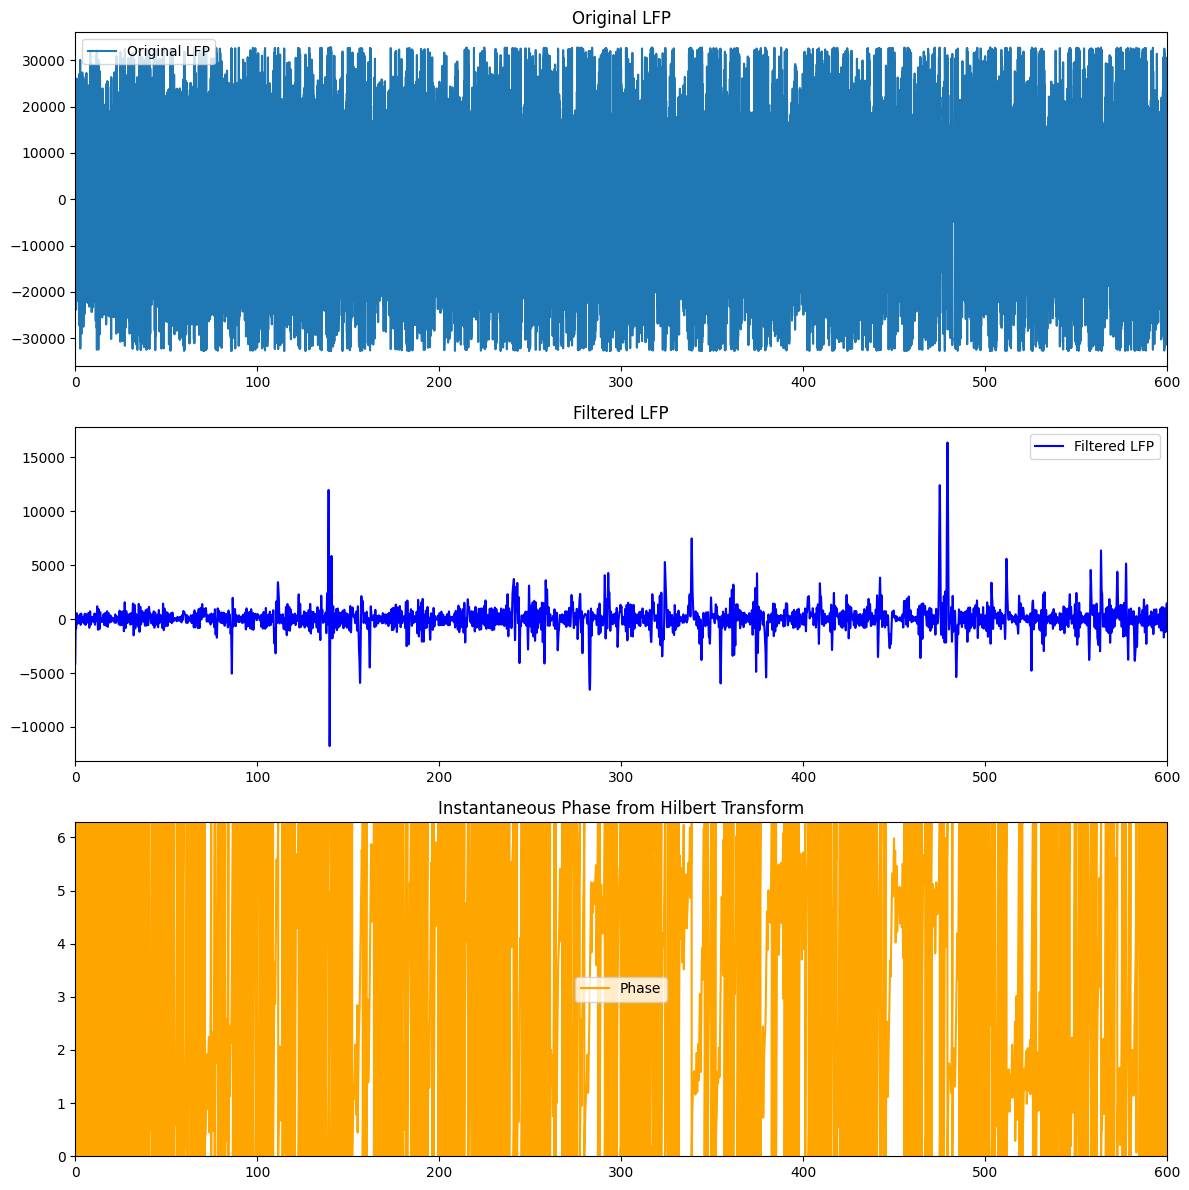

In [153]:
import matplotlib.pyplot as plt
def plot_lfp_and_hilbert(lfp, sampling_rate, peakFreq, filtHalfBandWidth):
    """
    Plot the LFP and its Hilbert transform.

    Parameters:
    - lfp: Local Field Potential time series.
    - sampling_rate: The sampling rate of the LFP.
    - peakFreq: The central frequency around which the LFP is filtered.
    - filtHalfBandWidth: Half bandwidth for filtering. Default is 3 Hz.
    
    Returns:
    - A plot displaying the LFP, its filtered version, and the phase from the Hilbert transform.
    """
    
    # Create a time vector
    t = np.arange(0, len(lfp)/sampling_rate, 1/sampling_rate)
    
    # FILTER THE LFP AROUND THE PEAK FREQUENCY
    nyq = 0.5 * sampling_rate
    low = (peakFreq - filtHalfBandWidth) / nyq
    high = (peakFreq + filtHalfBandWidth) / nyq
    taps = firwin(round(sampling_rate) + 1, [low, high], pass_zero=False, window='blackman', fs=sampling_rate)
    padlen = min(3 * (len(taps) - 1), len(lfp) - 1)
    theta_lfp = filtfilt(taps, 1, lfp, padlen=padlen)

    # Extract instantaneous phase using Hilbert transform
    analytic_signal = hilbert(theta_lfp)
    eegPhase = np.angle(analytic_signal)
    eegPhase = np.mod(eegPhase, 2 * np.pi)
    
    # Plot
    fig, ax = plt.subplots(3, 1, figsize=(12, 12))

    # Plot the original LFP
    ax[0].plot(t, lfp, label='Original LFP')
    ax[0].set_title('Original LFP')
    ax[0].set_xlim([0, t[-1]])
    ax[0].legend()

    # Plot the filtered LFP
    ax[1].plot(t, theta_lfp, label='Filtered LFP', color='blue')
    ax[1].set_title('Filtered LFP')
    ax[1].set_xlim([0, t[-1]])
    ax[1].legend()

    # Plot the instantaneous phase
    ax[2].plot(t, eegPhase, label='Phase', color='orange')
    ax[2].set_title('Instantaneous Phase from Hilbert Transform')
    ax[2].set_xlim([0, t[-1]])
    ax[2].set_ylim([0, 2 * np.pi])
    ax[2].legend()

    plt.tight_layout()
    plt.show()

plot_lfp_and_hilbert(lfp_data_for_channel, 1000, peakFreq = 8, filtHalfBandWidth = 3)